In [2]:
# import the mathematical libraries required
import pandas 
import nsepy as nse
from pandas_datareader import data as pd 
import numpy as np
from math import sqrt, pi
import matplotlib as mat 
import matplotlib.pyplot as plt
mat.style.use('ggplot') # I personally find this style to be elegant
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# import standard python libraries
import time
import datetime as dt 

# magic functions for plotting and for development of nambiarbsfkit
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import homebrew kit for black scholes framework analysis
import nambiarbsfkit as nk 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Dummy analysis for interpreting the Black Scholes model

# underlying stock price
S = 45.0

# series of underlying stock prices to demonstrate a payoff profile (assumed to be increasing linearly)
S_ = np.arange(40.0, 50.0, 0.01)

# strike price
K = 45.0

# time to expiration ( we'll see this as the T-t in the equation)
t = 164.0 / 365.0 

#risk free rate
r = 0.02

# volatility (assumption)
vol = 0.25

We are analysing options for the NIFTY 50 Index. Since index options in India follow the European style where we can only execute the option after the specified time, we will be using the famous Black-Scholes pricing formula since some of the model's key assumptions fit perfectly to our asset. European and Plain Vanilla. 

Most derivatives have a payoff function which describes the value at the end of the life of the contract (expiration). For a call option, the payoff can be expressed simply as:

> $$C(S, K) = max(S-K, 0)$$

While the payoff for a put option can be expressed as:

> $$P(K, S) = max(K-S, 0)$$

Where $S$ and $K$ are defined above. In this case, $K$ remains fixed during the life of a contract while the underlying stock price, $S$, fluctuates..

Across a range of potential $S$ values, we can form what is commonly known as the payoff (or risk profile or PnL chart) for an option at expiration.

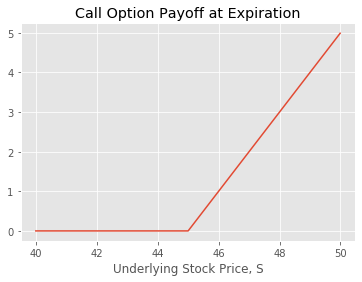

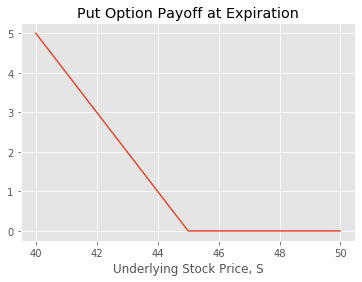

In [6]:
# call payoff lambda function 
call_payoff = lambda S, K: np.maximum(S - K, 0.0)

# put payoff lambda function 
put_payoff = lambda S, K: np.maximum(K - S, 0.0)

# plot the call payoff
plt.figure(1)
plt.title('Call Option Payoff at Expiration')
plt.xlabel('Underlying Stock Price, S')
plt.plot(S_, call_payoff(S_, K))

# plot the put payoff
plt.figure(2)
plt.title('Put Option Payoff at Expiration')
plt.xlabel('Underlying Stock Price, S')
plt.plot(S_, put_payoff(S_, K))

The Black–Scholes model assumes that the market consists of at least one risky asset, usually called the stock, and one riskless asset, usually called the money market, cash, or bond.

Assumptions on the market:

* The rate of return on the riskless asset is constant and thus called the risk-free interest rate
* The instantaneous log returns of the stock price is an infinitesimal random walk with drift and volatility (geometric Brownian motion) and assumes this drift and volatility are constant
* The stock does not pay a dividend

Assumptions on the underlying security:

* There is no arbitrage opportunity (i.e. there is no way to make a riskless profit)
* It is possible to borrow and lend any amount, even fractional, of cash at the riskless rate
* It is possible to buy and sell any amount, even fractional, of the stock (this includes short selling)
* The above transactions do not incur any fees or costs (i.e. frictionless market).

Source: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model


- ### The Black-Scholes Model

> $$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} V}{\partial S^{2}}+rS\frac{\partial V}{\partial S}-rV=0$$

The key financial insight behind the equation is that one can perfectly hedge the option by buying and selling the underlying asset in just the right way and consequently create an arbitrage free environment. This hedge, in turn, implies that there is only one right price for the option, as returned by the Black–Scholes formula. For this dynamic hedging to work, one must continuously hedge the movement in the underlying stock with the option which in reality, is prohibitive due to transaction costs.

For a Call Option

> $$C(S, t) = N(d_{1})S - N(d_{2})Ke^{-r(T-t)}$$

For a Put Option

> $$P(S, t) = N(-d_{2})Ke^{-r(T-t)} - N(-d_{1})S$$

where

> $$d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}}$$

and

> $$d_{2} = d_{1} - \sigma\sqrt{T-t}$$

where

* $N(\cdot)$ is the cumulative distribution function of the standard normal distribution
* $T - t$ is the time to maturity ($t$ is used in the code)
* $S$ is the spot price of the underlying asset
* $K$ is the strike price
* $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
* $\sigma$ is the volatility of returns of the underlying asset ($vol$ is used in the code)

In [8]:
# these functions are also present in the nambiarbsfkit module
def N(z):
    '''
    Normal cumulative density function which returns the 
    cumulative density under the normal curve along the 
    point 'z' where the cumulative density is calculated.
    Refer to scipy.stats documentation for more information
    '''
    from scipy.stats import norm

    return norm.cdf(z)


def call_value(S, K, r, t, vol):
    '''
    Returns the Black-Scholes call option value where
    the parameters have their usual meanings.

    :param S : Underlying stock price
    :param K : Strike price
    :param r : Risk free rate (Usually treasury bond rates or bank rates)
    :param vol : volatility of the stock
    :param t : time to expiration (T - t in documentation)
    '''
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S / K) + t * (r + (vol ** 2.0) / 2))
    d2 = d1 - vol * np.sqrt(t)

    return N(d1) * S - N(d2) * K * np.exp(-r * t)

def put_value(S, K, r, t, vol):
    '''
    Returns the Black-Scholes put option value where
    the parameters have their usual meanings.

    :param S : Underlying stock price
    :param K : Strike price
    :param r : Risk free rate (Usually treasury bond rates or bank rates)
    :param vol : volatility of the stock
    :param t : time to expiration (T - t in documentation)
    '''
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S / K) + t * (r + (vol ** 2.0) / 2))
    d2 = d1 - vol * np.sqrt(t)

    return  N(-d2) * K * np.exp(-r * t) - N(-d1) * S

In [10]:
# using the functions for option values on nambiarbsfkit 
print('Black-Scholes Call Value', round(nk.call_value(S, K, r, t,vol), 2))
print('Black-Scholes Put Value', round(nk.put_value(S, K, r, t,vol), 2))

Black-Scholes Call Value 3.2
Black-Scholes Put Value 2.79


Since we have vectorised the function, we can plot the Black-Scholes call value along a range of underlying stock prices. Let us see what the valuations look like with six, three and one month left to expiration. 

In [12]:
# call value of option with six months to expire
bs_call_six_month = nk.call_value(S_, K, r, 0.5, vol) # time is used as a ratio since annualised risk free rate is used 

# call value of option with three months to expire
bs_call_three_month = nk.call_value(S_, K, r, 0.25, vol) # time is used as a ratio since annualised risk free rate is used 

# call value of option with one months to expire
bs_call_one_month = nk.call_value(S_, K, r, 1 / 12.0, vol) # time is used as a ratio since annualised risk free rate is used 

# get payoff value at expiration
call_payoff_at_expiration = call_payoff(S_, K)

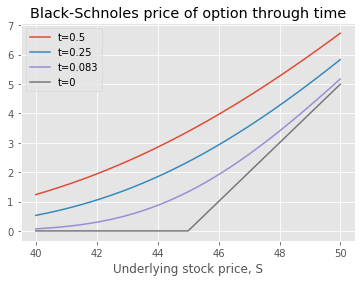

In [14]:
# plot call payoffs
plt.figure(3)
plt.plot(S_, bs_call_six_month)
plt.plot(S_, bs_call_three_month)
plt.plot(S_, bs_call_one_month)
plt.plot(S_, call_payoff_at_expiration)
plt.title('Black-Schnoles price of option through time')
plt.xlabel('Underlying stock price, S')
plt.legend(['t=0.5', 't=0.25', 't=0.083', 't=0'], loc=2)

- ### Greek Analysis

Mathematically, the Greeks are the partial derivatives of the option pricing formula. Analytically, they are the sensitivities in the movement of the option price relative to the movement of various aspects of the input variables.

Apart from being used as a pricing model, the Black-Scholes model is useful to find the Greeks which give us a good understanding of these sensitivities.

The most common Greeks which we will analyse are as follows.

- **Delta**. Partial Derivative of the option value with respect to the change in the underlying stock price. Measures how the underlying option moves with respect to moves in underlying stock.

>Call Delta $$ \frac{\partial V}{\partial S} = N(d_1) $$
>Put Delta $$ \frac{\partial V}{\partial S} = N(d_1) - 1 $$

- **Gamma**. Second partial derivative of the option value with respect to the price of the underlying stock price. Gamma measures the convexity in the value of the option with respect to the underlying.

>Gamma (same for call and put) $$ \frac{\partial^2 V}{\partial S^2} = \frac{\phi (d_1)}{S\sigma \sqrt{T-t}} $$

- **Vega**. Partial derivative of the option value with respect to the change in volatility of the underlying. Vega measures how the option price moves with respect to the volatility of the underlying. 

>Vega (same for call and put) $$ \frac{\partial V}{\partial \sigma} = S\phi(d_1) \sqrt{T-t} $$

- **Theta**. Partial derivative of the option value with respect to the change in time. Shows the decay of value of option as time passes.

>Call Theta $$ \frac{\partial V}{\partial t} = - \frac{S\phi(d_1)\sigma}{2\sqrt{T-t}} - r K e^{-r(T-t)}N(d_2)$$
>Put Theta $$ \frac{\partial V}{\partial t} = - \frac{S\phi(d_1)\sigma}{2\sqrt{T-t}} + r K e^{-r(T-t)}N(-d_2)$$

- **Rho**. Partial derivative of the option value with respect to change in the risk-free interest rate. Rho measures how the option value changes as the interest rate changes.

> Call rho
> $$\frac{\partial V}{\partial r} = K(T-t)e^{-r(T-t)}N(d_2)$$

> Put rho
> $$\frac{\partial V}{\partial r} = -K(T-t)e^{-r(T-t)}N(-d_2)$$

Where $\phi$ (helper function)

> $$\phi(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}$$

and $N(\cdot)$, $d_1$ and $d_2$ are defined above.

In [16]:
# these functions are also present in the nambiarbsfkit module
def phi(x):
    '''
    Phi Helper Function. 
    '''
    import math
    from math import pi
    return np.exp(-0.5 * x**2) / (math.sqrt(2.0 * pi))

def call_delta(S, K, r, t, vol):
    '''
    Black-Scholes Call Delta.
    Partial derivative of the option value 
    with respect to the change in the underlying stock price. 
    Delta measures how the underlying option moves 
    with respect to moves in the underlying stock.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility
    '''
    d1 = (1/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol **2.0) * t)
    return N(d1)

def put_delta(S, K, r, t, vol):
    '''
    Black-Scholes Put Delta.
    Partial derivative of the option value 
    with respect to the change in the underlying stock price. 
    Delta measures how the underlying option moves 
    with respect to moves in the underlying stock.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility
    '''
    d1 = (1.0/(vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2.0) * t)
    
    return N(d1) - 1.0

def gamma(S, K, r, t, vol):
    '''
    Black-Scholes Gamma.
    Second partial derivative of the option value with respect
    to the change in the underlying stock price. Gamma measures movements in delta
    or the convexity in the value of the option with respect to the underlying.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility 
    '''
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2.0) * t)

    return phi(d1) / (S * vol * np.sqrt(t))

def vega(S, K, r, t, vol):
    '''
    Black-Scholes Vega. (Returns percentage)
    Partial derivative of the option value with respect to 
    the change in the volatility of the underling. Vega measures 
    how the option price moves with respect to the volatility of the underlying.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility 
    '''
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2.0) * t)
    return S * phi(d1) * np.sqrt(t) / 100 

def call_theta(S, K, r, t, vol):
    '''
    Black-Scholes Call Theta(Annualised).
    Partial derivative of the option value with respect to the change in time. 
    Shows the decay of value of option as time passes.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility
    '''

    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t)) 

    theta = (-S * phi(d1) * vol) / (2 * np.sqrt(t)) - (r * K * np.exp(-r * t) * N(d2))
    return theta / 365.0

def put_theta(S, K, r, t, vol):
    '''
    Black-Scholes Put Theta(Annualised).
    Partial derivative of the option value with respect to the change in time. 
    Shows the decay of value of option as time passes.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility
    '''

    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t)) 

    theta = (-S * phi(d1) * vol) / (2 * np.sqrt(t)) + (r * K * np.exp(-r * t) * N(-d2))
    return theta / 365.0

def call_rho(S, K, r, t, vol):
    '''
    Black-Scholes Call Rho.(Returns Percentage)
    Partial derivative of the option value with respect to change in the risk-free interest rate. 
    Rho measures how the option value changes as the interest rate changes.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility
    '''
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2) * t)
    d2 = d1 - (vol * np.sqrt(t))

    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100.0

def put_rho(S, K, r, t, vol):
    '''
    Black-Scholes Put Rho.(Returns Percentage)
    Partial derivative of the option value with respect to change in the risk-free interest rate. 
    Rho measures how the option value changes as the interest rate changes.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param vol: volatility
    '''
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S/K) + (r + 0.5 * vol ** 2) * t)
    d2 = d1 - (vol * np.sqrt(t))

    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100.0


In [18]:
# using nambiarbsfkit module, print each of the greeks for the dummy variable set
print('Black-Scholes Call Delta', round(nk.call_delta(S, K, r, t,vol), 4))
print('Black-Scholes Put Delta', round(nk.put_delta(S, K, r, t,vol), 4))
print('Black-Scholes Gamma', round(nk.gamma(S, K, r, t,vol), 4))
print('Black-Scholes Vega', round(nk.vega(S, K, r, t,vol), 4))
print('Black-Scholes Call Theta', round(nk.call_theta(S, K, r, t,vol), 4))
print('Black-Scholes Put Theta', round(nk.put_theta(S, K, r, t,vol), 4))
print('Black-Scholes Call Rho', round(nk.call_rho(S, K, r, t,vol), 4))
print('Black-Scholes Put Rho', round(nk.put_rho(S, K, r, t,vol), 4))

Black-Scholes Call Delta 0.5546
Black-Scholes Put Delta -0.4454
Black-Scholes Gamma 0.0524
Black-Scholes Vega 0.1192
Black-Scholes Call Theta -0.0103
Black-Scholes Put Theta -0.0078
Black-Scholes Call Rho 0.0978
Black-Scholes Put Rho -0.1026


- ### Implied Volatility Analysis

Apart from being used to calculate the option value, the Black-Scholes formula is also used to calculate the implied volatility of the underlying.The implied volatility is generally used for making trading decisions, calibrating other more exotic securities and researching market anomalies. Many traders use the so called volatility skew to understand the relative value of an option to other options trading in the market. 

To calculate the implied volatility, we set the Black-Scholes pricing formula equal to the market observed price and using a root finding algorithm, we solve for the volatility parameter which minimises the error between model and market price of the option. 

We will be using two methods to find the implied volatility. 

First, we will create an objective function which we'll pass to the Scipy implementation of the [Brentq algorithm](https://en.wikipedia.org/wiki/Brent%27s_method). Then we'll create an implied volatilty function to return the volatility parameter that sets the observed market price to the model price.

Second, we will use [ARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) and [GARCH](https://www.investopedia.com/terms/g/garch.asp) techniques to model the same.



In [20]:
def call_implied_volatility_objective_function(S, K, r, t, vol, call_option_market_price):
    '''
    Objective function which minimises the error between model and market prices.
    This will be sent to the optimizer.

    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param call_option_market rate: market observed option price
    :param vol: volatility of the underlying price
    '''

    return call_option_market_price - call_value(S, K, r, t, vol)

def call_implied_volatility_brent(S, K, r, t, call_option_market_price, a = -2.0, b = 2.0, xtol = 1e-6):
    '''
    Returns the implied volatility using Brent's Algorithm.
    
    :param S: underlying stock price
    :param K: strike price
    :param r: risk free rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper bound for brentq method
    :param xtol: tolerance of error which is considered good enough
    '''

    # avoid mirroring outer scope
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price

    # define a nested function that takes our nested param as the input 
    def fcn(vol):

        # returns the difference between market and model price at the given volatility
        return call_implied_volatility_objective_function(_S, _K, _r, _t, vol, _call_option_market_price)

    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a = a, b = b, xtol = xtol)

        # if the results are too small, we return nan so that we can later interpolate
        return np.nan if result < xtol else result
    
    # if it fails then we return nan so that we can later interpolate
    except ValueError:
        return np.nan  

def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    '''
    Objective function which minimises the error between model and market prices.
    This will be sent to the optimizer.
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    '''
    return put_option_market_price - put_value(S, K, r, t, vol)

def put_implied_volatility_brent(S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6):
    '''
    Returns the implied volatility using Brent's Algorithm.
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    '''
    
    # avoid mirroring out scope  
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price
    
    # define a nsted function that takes our target param as the input
    def fcn(vol):
        
        # returns the difference between market and model price at given volatility
        return put_implied_volatility_objective_function(_S, _K, _r, _t, vol, _put_option_market_price)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)
        
        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

In [22]:
# get the call and put values for the dummy underlying
call_model_price = nk.call_value(S, K, r, t, vol)
put_model_price = nk.put_value(S, K, r, t, vol)

# test the implied volatilities for both the options
print('Call implied volatility if the model and market prices were equal:', round(nk.call_implied_volatility_brent(S, K, r, t, call_model_price),7))
print('Put implied volatility if the model and market prices were equal:', round(nk.put_implied_volatility_brent(S, K, r, t, put_model_price),7))


Call implied volatility if the model and market prices were equal: 0.2500002
Put implied volatility if the model and market prices were equal: 0.2500002


- ### Getting Real Nifty Options Data

Using [Pandas](https://pandas.pydata.org/docs/) and [NSEpy](https://nsepy.readthedocs.io/en/latest/) we can get real time option data of securities being traded on the National Stock Exchange of India. Chains include all options of all strikes and expirations for a particular underlying stock, which are returned in a `MultiIndex pandas.DataFrame` object. 

In [24]:
# underlying stock symbol
underlying_symbol = 'NIFTY'

# define a Options object
options_obj = pd.Options('NIFTY', 'nse')

# requests all chains for the underlying symbol
# ** THIS MIGHT TAKE A WHILE**
option_frame_live = options_obj.get_all_data()

# let us save(pickle) this DataFrame
options_fram_live.to_pickle('options_frame.pickle')

NotImplementedError: currently only yahoo supported